# Entrenamiento modelos de forma diaria:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
import re
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
color_palette = sns.color_palette()

2025-04-22 11:42:57.901082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 11:42:57.917405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 11:42:58.076709: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 11:42:58.194885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745336578.316473  487743 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745336578.36

Cargamos los datos de la encuesta CADEM diaria y los features del dataset.

In [8]:
df = pd.read_csv("../data/processed_data.csv")
df_encuestas = pd.read_csv("../data/encuestas.csv")
df["date"] = pd.to_datetime(df["date"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
df_final = df.copy()
#df_encuestas = pd.read_csv("../data/encuesta.csv")

In [4]:
df_final.tail()

,type,id,url,twitterUrl,text,source,retweetCount,replyCount,likeCount,quoteCount,...,robertuito_758,robertuito_759,robertuito_760,robertuito_761,robertuito_762,robertuito_763,robertuito_764,robertuito_765,robertuito_766,robertuito_767
23269,tweet,1914165361454219605,https://x.com/Marisol02093983/status/191416536...,https://twitter.com/Marisol02093983/status/191...,debe rendir antecedentes país perdonamos salid...,NaN,3,0,4,0,...,0.070488,0.330716,-0.492225,1.715618,0.123890,0.097284,-0.770528,-0.790007,-0.154929,0.453781
23270,tweet,1914267268759830994,https://x.com/shamanikus/status/19142672687598...,https://twitter.com/shamanikus/status/19142672...,aqui dejo asi pensaba diputado boric president...,NaN,0,0,0,0,...,0.188477,1.222688,-0.667889,2.047169,-0.056446,0.351575,-1.119990,-1.468139,-0.493986,0.769680
23271,tweet,1914116044701999231,https://x.com/Cristin33004449/status/191411604...,https://twitter.com/Cristin33004449/status/191...,mira boric celebran ministerio seguridad da pe...,NaN,0,0,1,0,...,0.070955,1.013368,-0.425426,1.336909,-0.309498,0.355910,-0.805995,-1.245997,-0.124222,0.836881
23272,tweet,1914137401313939930,https://x.com/La_Pamelita_/status/191413740131...,https://twitter.com/La_Pamelita_/status/191413...,pasa cualquiera cree presidente allá respaldos...,NaN,2,0,3,0,...,-0.120997,0.600523,-0.082462,1.237640,-0.511896,-0.205377,-1.962169,-0.776372,-0.128209,0.857070
23273,tweet,1914152657586999650,https://x.com/NadiaMacarenaa/status/1914152657...,https://twitter.com/NadiaMacarenaa/status/1914...,presidente boric hora declara duelo nacional m...,NaN,0,1,1,0,...,0.482470,0.820125,-0.481872,1.503991,-0.301410,-0.037887,-1.236559,-0.386352,0.472336,1.314469


Configuramos como datetime las variables de fechas y creamos la variable week_start que define el inicio de la semana el dia domingo.

In [9]:
df["date"] = pd.to_datetime(df["date"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
df["week_start"] = df["date"] - pd.to_timedelta((df["date"].dt.weekday + 1) % 7, unit="D")
df_encuestas["week_start"] = df_encuestas["date"] - pd.to_timedelta((df_encuestas["date"].dt.weekday + 1) % 7, unit="D")
df_final = df.merge(df_encuestas[["week_start", "aprobacion_boric"]], on="week_start", how="left")
#df_final = df_final.sort_values("date").dropna()

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:1014: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:1018: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [10]:
#df_final["approval_rolling_7d"] = df_final["aprobacion_boric"].rolling(window=7, min_periods=7).mean()
df_final["approval_lag_7d"] = df_final["aprobacion_boric"].shift(1)
#df_final["approval_diff"] = df_final["aprobacion_boric"].diff()
#df_final["approval_pct_change"] = df_final["aprobacion_boric"].pct_change()
for lag in range(1, 8):  # Lags de 1 a 7 días
    df_final[f"score_positive_lag_{lag}"] = df_final["score_positive"].shift(lag)
    df_final[f"score_negative_lag_{lag}"] = df_final["score_negative"].shift(lag)
    df_final[f"score_neutral_lag_{lag}"] = df_final["score_neutral"].shift(lag)
df_final['score_negative_rolling7'] = df_final['score_negative'].rolling(window=7, min_periods=3).mean()
df_final['score_negative_rolling3'] = df_final['score_negative'].rolling(window=3, min_periods=3).mean()
df_final['sentiment_net'] = df_final['score_positive'] - df_final['score_negative']
df_final['sentiment_net_rolling7'] = df_final['sentiment_net'].rolling(window=7, min_periods=3).mean()

In [11]:
df_final.head()

,type,id,url,twitterUrl,text,source,retweetCount,replyCount,likeCount,quoteCount,...,score_positive_lag_6,score_negative_lag_6,score_neutral_lag_6,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling7
0,tweet,1498772521948045312,https://x.com/IndignadosRed/status/14987725219...,https://twitter.com/IndignadosRed/status/14987...,futuro ministro hacienda boric marcel reúne ba...,NaN,1,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.596141,NaN
1,tweet,1498715128686018561,https://x.com/TribunaC/status/1498715128686018561,https://twitter.com/TribunaC/status/1498715128...,gremios salud alerta designación delegado pres...,NaN,14,1,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.488988,NaN
2,tweet,1498804396976742400,https://x.com/SilvanaNHR/status/14988043969767...,https://twitter.com/SilvanaNHR/status/14988043...,schalper rol rn gobierno boric llamó atrofiar ...,NaN,1,1,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.526556,0.526556,-0.342033,-0.475721
3,tweet,1498636115259047936,https://x.com/elmundoes/status/149863611525904...,https://twitter.com/elmundoes/status/149863611...,independentismo estalla borrell tras decir zel...,NaN,823,407,4273,155,...,NaN,NaN,NaN,NaN,NaN,NaN,0.586219,0.571688,-0.748543,-0.543926
4,tweet,1498806122995613696,https://x.com/MarcoAntonio__R/status/149880612...,https://twitter.com/MarcoAntonio__R/status/149...,nivel amantes boric ex bibliotecario liceo b12...,NaN,11,11,37,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.655214,0.704004,-0.926406,-0.620422


In [ ]:
cols_to_scale = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount']
scaler = MinMaxScaler()
df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])
df_final = df_final.dropna()

In [1]:
target = 'aprobacion_boric'
X = df_final.drop(columns=['week_start', 'aprobacion_boric', 'desaprobacion_boric'], errors='ignore')
X = X.select_dtypes(exclude=['datetime'])

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_final[[target]])

NameError: name 'df_final' is not defined

In [51]:
df_final.tail(10)

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_6,score_negative_lag_6,score_neutral_lag_6,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling7
1123,2025-03-28,0.101121,0.519149,0.379730,0.131164,0.027591,0.052657,0.007051,0.310492,0.615344,...,0.158460,0.491210,0.350331,0.246203,0.471909,0.281888,0.433286,0.469274,-0.418027,-0.260373
1124,2025-03-29,0.141889,0.324145,0.533966,0.097481,0.026934,0.056788,0.004242,0.110955,0.259160,...,0.149820,0.511189,0.338990,0.158460,0.491210,0.350331,0.409419,0.393553,-0.182256,-0.238874
1125,2025-03-30,0.143335,0.434672,0.421994,0.103023,0.023042,0.035957,0.003727,0.042939,0.652956,...,0.197782,0.262605,0.539613,0.149820,0.511189,0.338990,0.398488,0.425988,-0.291337,-0.228869
1140,2025-04-14,0.211345,0.383933,0.404722,0.038188,0.010862,0.014567,0.001166,0.252927,0.471234,...,0.253291,0.256142,0.490567,0.079328,0.561452,0.359219,0.421666,0.490982,-0.172588,-0.246890
1141,2025-04-15,0.128366,0.494115,0.377519,0.113283,0.051044,0.055872,0.007751,0.136343,0.371884,...,0.217047,0.344908,0.438045,0.253291,0.256142,0.490567,0.455662,0.473311,-0.365749,-0.298732
1142,2025-04-16,0.045629,0.675566,0.278805,0.017352,0.001824,0.008207,0.000000,0.280603,0.393599,...,0.138421,0.322291,0.539288,0.217047,0.344908,0.438045,0.502899,0.517871,-0.629938,-0.370457
1143,2025-04-17,0.100585,0.563863,0.335552,0.007602,0.000458,0.007895,0.001243,0.123330,0.449426,...,0.124856,0.555379,0.319765,0.138421,0.322291,0.539288,0.537410,0.577848,-0.463278,-0.410373
1144,2025-04-18,0.121163,0.561869,0.316968,0.068447,0.063299,0.032231,0.006612,0.106784,0.500454,...,0.142172,0.547127,0.310701,0.124856,0.555379,0.319765,0.538337,0.600433,-0.440706,-0.411828
1145,2025-04-19,0.115589,0.569655,0.314755,0.038386,0.009378,0.015181,0.002086,0.091602,0.475883,...,0.136304,0.541885,0.321811,0.142172,0.547127,0.310701,0.541555,0.565129,-0.454066,-0.418844
1146,2025-04-20,0.063680,0.688488,0.247833,0.057660,0.047796,0.017557,0.004798,0.163606,0.382131,...,0.211345,0.383933,0.404722,0.136304,0.541885,0.321811,0.562498,0.606671,-0.624808,-0.450162


Ahora creamos la base más básica, sólamente con los scores, para correr una regresión lineal simple.

In [64]:
 # Se excluye 'date' porque no es numérica
y = df_final['aprobacion_boric']  # Variable objetivo

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Guardar las fechas desde el DataFrame original
fechas = df_final['date'].reset_index(drop=True)
fechas_train, fechas_test = train_test_split(fechas, test_size=0.3, random_state=42)

## Random Forest:

Comenzamos con un modelo de Random Forest.

In [65]:
modelo_rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

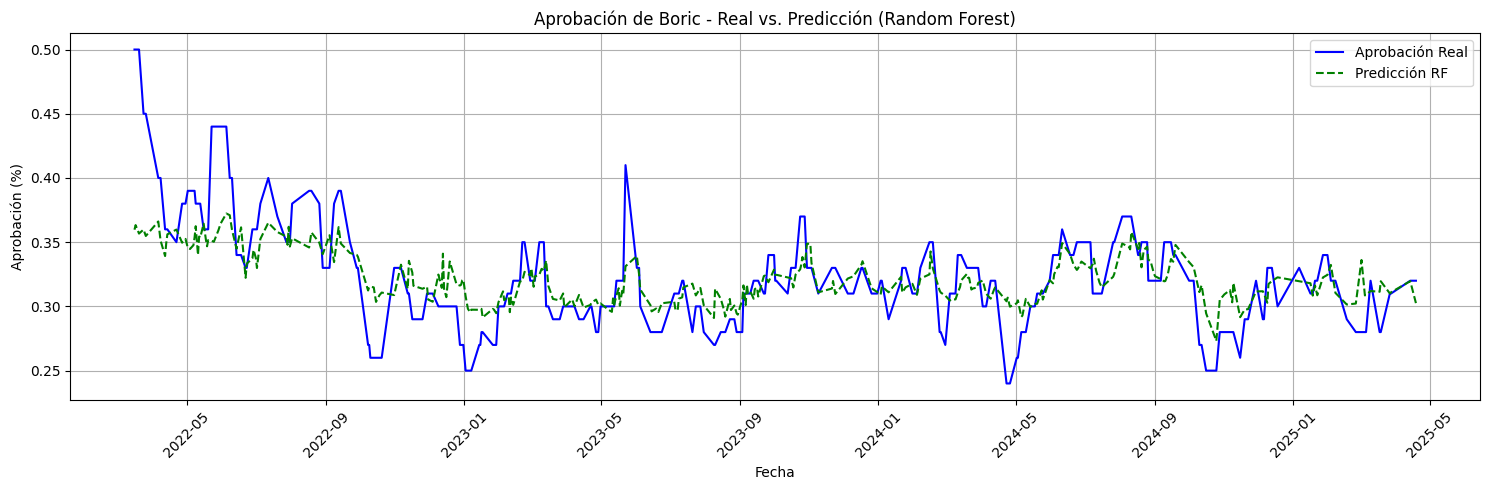

In [54]:
y_test_real = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(np.array(y_pred_rf).reshape(-1, 1)).flatten()

df_results = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real,
    'Predicción Random Forest': y_pred_real
}).sort_values(by='Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_results['Fecha'], df_results['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_results['Fecha'], df_results['Predicción Random Forest'], linestyle='--', color='green', label='Predicción RF')

plt.title('Aprobación de Boric - Real vs. Predicción (Random Forest)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Veamos la calidad de la predicción analizando la calidad o importancia de las variables predictoras:

In [55]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# === 2. Mostrar las top 15 variables ===
print("🎯 Variables más importantes (top 15):")
print(importancias.head(15))

🎯 Variables más importantes (top 15):
                    Variable  Importancia
787      approval_rolling_7d     0.143329
788          approval_lag_7d     0.070343
791   disapproval_rolling_7d     0.062374
792       disapproval_lag_7d     0.036865
558           robertuito_551     0.008977
221           robertuito_214     0.007833
335           robertuito_328     0.006217
441           robertuito_434     0.005719
816  score_negative_rolling7     0.005430
36             robertuito_29     0.004953
330           robertuito_323     0.004949
251           robertuito_244     0.004942
380           robertuito_373     0.004930
657           robertuito_650     0.004680
756           robertuito_749     0.004282


In [56]:
top_vars = importancias.head(15)['Variable'].tolist()

target = 'aprobacion_boric'
df_model = df_final.copy()
df_model = df_model.dropna(subset=top_vars + [target])  # Eliminar filas con NaN en las variables clave

X_top = df_model[top_vars]
y = df_model[target]
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# Desescalar
y_test_real_rf = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_rf = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Métricas
mae = mean_absolute_error(y_test_real_rf, y_pred_real_rf)
r2 = r2_score(y_test_real_rf, y_pred_real_rf)

print(f"🌲 Random Forest con X_top - MAE: {mae:.4f}, R²: {r2:.4f}")

🌲 Random Forest con X_top - MAE: 0.0109, R²: 0.8727


In [57]:
# Crear DataFrame con resultados
df_resultado = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_rf,
    'Predicción RF': y_pred_real_rf
}).sort_values('Fecha')  # ordenar cronológicamente

plt.figure(figsize=(15, 5))
plt.plot(df_resultado['Fecha'], df_resultado['Aprobación Real'], label='Real', color='blue')
plt.plot(df_resultado['Fecha'], df_resultado['Predicción RF'], label='Predicción RF', color='green', linestyle='--')
plt.title('Aprobación Boric - Real vs Predicción (Random Forest con X_top)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

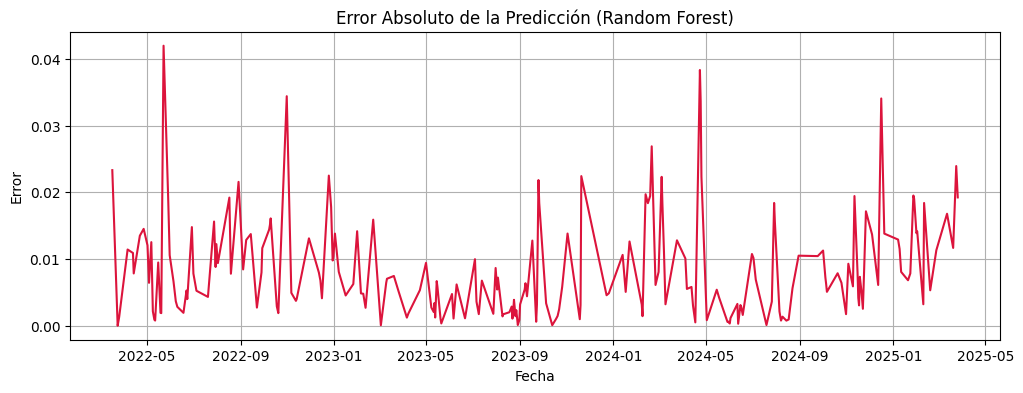

In [58]:
df_resultado['Error Absoluto'] = np.abs(df_resultado['Aprobación Real'] - df_resultado['Predicción RF'])
plt.figure(figsize=(12, 4))
plt.plot(df_resultado['Fecha'], df_resultado['Error Absoluto'], label='Error Absoluto', color='crimson')
plt.title('Error Absoluto de la Predicción (Random Forest)')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [25]:
# Agregar columna de error absoluto
df_resultado['Error Absoluto'] = np.abs(df_resultado['Aprobación Real'] - df_resultado['Predicción RF'])
top_errores = df_resultado.sort_values(by='Error Absoluto', ascending=False).head(10)
print(top_errores[['Fecha', 'Aprobación Real', 'Predicción RF', 'Error Absoluto']])

         Fecha  Aprobación Real  Predicción RF  Error Absoluto
57  2022-05-23             0.44       0.398010        0.041990
84  2024-04-23             0.24       0.278349        0.038349
36  2022-10-31             0.33       0.295582        0.034418
216 2024-12-16             0.30       0.334080        0.034080
73  2024-04-24             0.24       0.273685        0.033685
82  2024-12-17             0.30       0.328963        0.028963
107 2024-02-20             0.28       0.306904        0.026904
42  2025-03-24             0.31       0.286055        0.023945
178 2022-03-17             0.50       0.476669        0.023331
59  2022-12-25             0.30       0.322513        0.022513


## XGBoost:

In [59]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="mae",
    early_stopping_rounds=20,
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"⚡ XGBoost - MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

# Paquete de todo lo necesario para reproducir predicciones
modelo_dict = {
    "model": xgb_model,
    "X": X_scaled,  # opcional si quieres reproducibilidad
    "y": y_scaled,  # opcional
    "feature_names": top_vars
}

# Guardar en un solo archivo pkl
joblib.dump(modelo_dict, "../models/modelo_aprobacion.pkl")

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


⚡ XGBoost - MAE: 0.03, R²: 0.93


['../models/modelo_aprobacion.pkl']

In [43]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con R²
r2_scores = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    scoring='r2',
    cv=10,  # Aumentamos a 10 folds
    n_jobs=-1
)

print("🔁 Validación cruzada (R²):")
print("Scores por fold:", r2_scores)
print("Media:", r2_scores.mean())
print("Desviación estándar:", r2_scores.std())

🔁 Validación cruzada (R²):
Scores por fold: [0.95469358 0.93320695 0.94167012 0.93973093 0.92032052 0.94756829
 0.95402874 0.91363221 0.94929945 0.95941124]
Media: 0.9413562030681568
Desviación estándar: 0.014305309572847936


In [44]:
y_test_real_xgb = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_xgb = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

df_results = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_xgb,
    'Predicción XGBoost': y_pred_real_xgb
})


df_results = df_results.sort_values(by='Fecha')
plt.figure(figsize=(15, 5))
plt.plot(df_results['Fecha'], df_results['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_results['Fecha'], df_results['Predicción XGBoost'], linestyle='--', color='orange', label='Predicción XGBoost')
plt.title('Aprobación de Boric - Real vs. Predicción (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

ValueError: All arrays must be of the same length

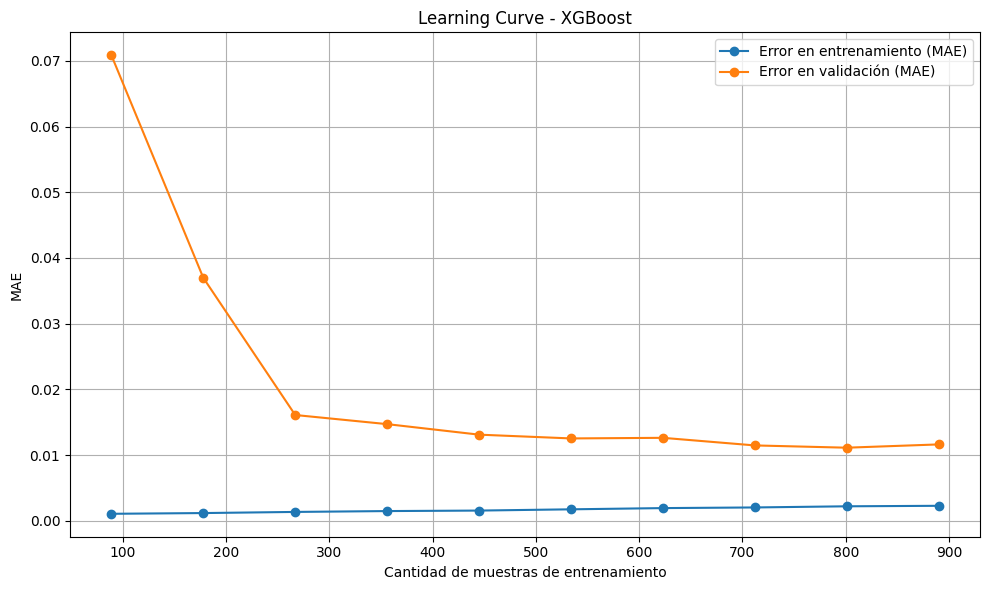

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# Definir modelo con los mejores hiperparámetros encontrados
modelo = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Usar MAE como métrica de evaluación
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=mae_scorer,
    n_jobs=-1
)

# Promedio y desviación de los errores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Error en entrenamiento (MAE)")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Error en validación (MAE)")
plt.xlabel("Cantidad de muestras de entrenamiento")
plt.ylabel("MAE")
plt.title("Learning Curve - XGBoost")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

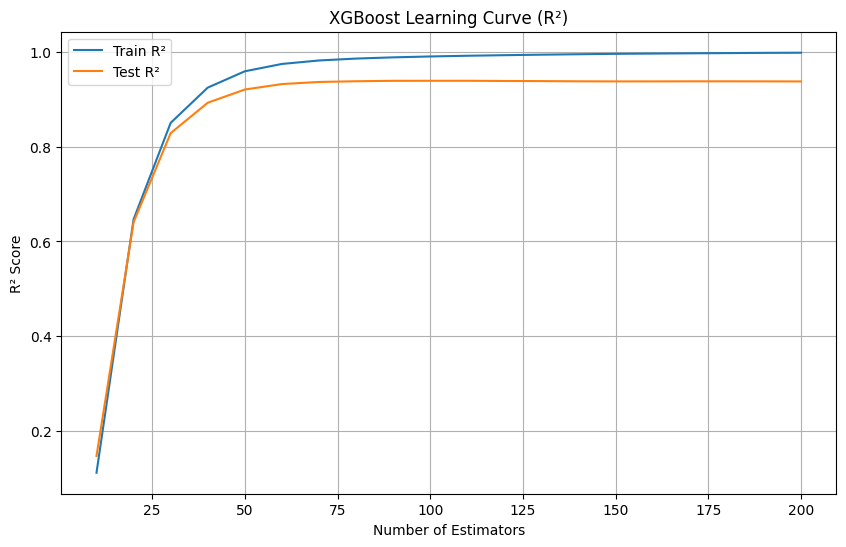

In [46]:
from sklearn.metrics import r2_score

r2_train = []
r2_test = []

# Entrenar en pasos de 10 iteraciones
for i in range(10, 201, 10):  # Ajusta el rango si necesitas más iteraciones
    model = xgb.XGBRegressor(
        objective="reg:squarederror", 
        n_estimators=i,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8, 
        colsample_bytree=0.8, 
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predicciones y R²
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_test.append(r2_score(y_test, y_test_pred))

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(range(10, 201, 10), r2_train, label="Train R²")
plt.plot(range(10, 201, 10), r2_test, label="Test R²")
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("XGBoost Learning Curve (R²)")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
from sklearn.model_selection import cross_val_score

xgb_model_cv = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100,  # según tu gráfico, esto es suficiente
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8,
    random_state=42
)

# Validación cruzada con 5 folds
scores = cross_val_score(xgb_model_cv, X_train, y_train, 
                         scoring='r2', cv=5)

# Resultados
print("🔍 Validación cruzada (R²):")
print(f"Scores por fold: {scores}")
print(f"Media: {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

🔍 Validación cruzada (R²):
Scores por fold: [0.95385181 0.92943561 0.90510787 0.91969244 0.94657292]
Media: 0.931
Desviación estándar: 0.018


## KNN:

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn_model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(X_test_scaled)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"📊 KNN - MAE: {mae_knn:.4f}, R²: {r2_knn:.4f}")

📊 KNN - MAE: 0.0536, R²: 0.8116


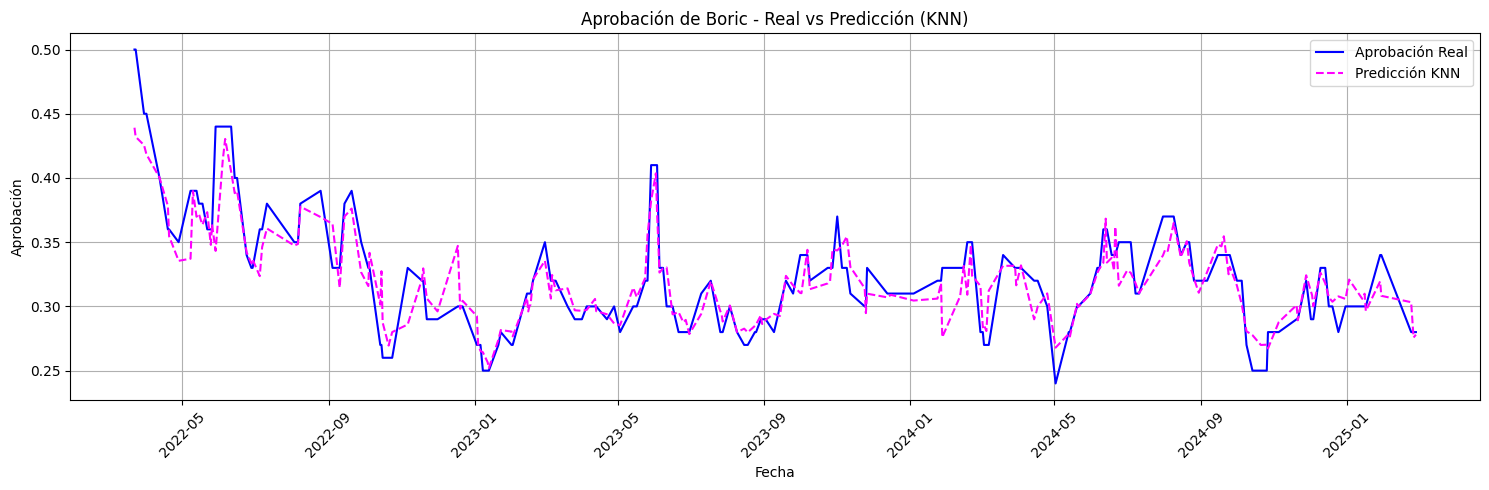

In [90]:
y_pred_real_knn = scaler_y.inverse_transform(y_pred_knn.reshape(-1, 1)).flatten()
y_test_real_knn = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

df_knn = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_knn,
    'Predicción KNN': y_pred_real_knn
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_knn['Fecha'], df_knn['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_knn['Fecha'], df_knn['Predicción KNN'], label='Predicción KNN', color='magenta', linestyle='--')

plt.title('Aprobación de Boric - Real vs Predicción (KNN)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

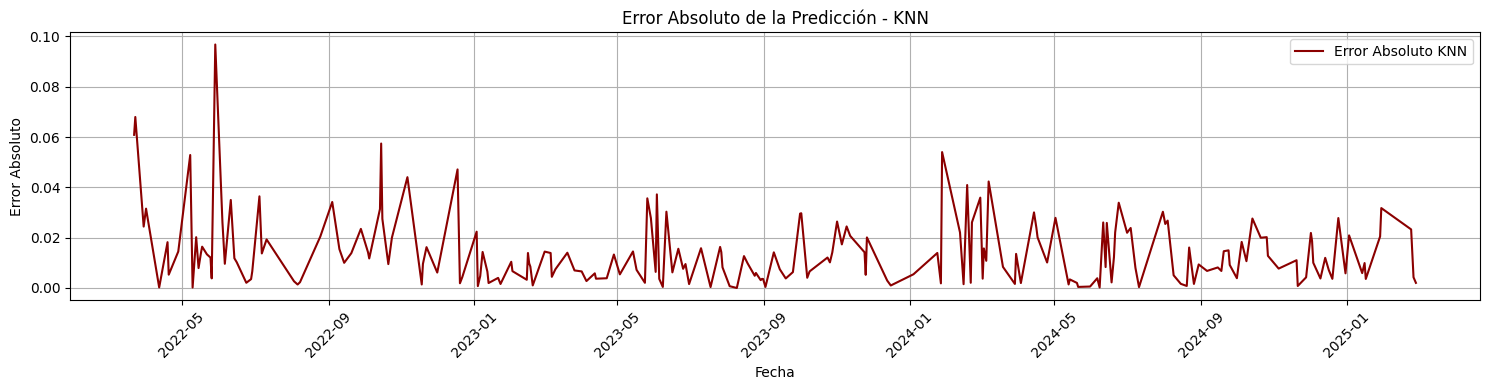

In [91]:
df_knn['Error Absoluto'] = np.abs(df_knn['Aprobación Real'] - df_knn['Predicción KNN'])
plt.figure(figsize=(15, 4))
plt.plot(df_knn['Fecha'], df_knn['Error Absoluto'], color='darkred', label='Error Absoluto KNN')
plt.title('Error Absoluto de la Predicción - KNN')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MLP:

In [92]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # salida para regresión
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict(X_test).flatten()
y_test_real_mlp = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_mlp = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_real_mlp, y_pred_real_mlp)
r2 = r2_score(y_test_real_mlp, y_pred_real_mlp)

print(f"🤖 MLP - MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 1/100


/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0759 - val_loss: 0.0094
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0039
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0043
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0038
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_lo

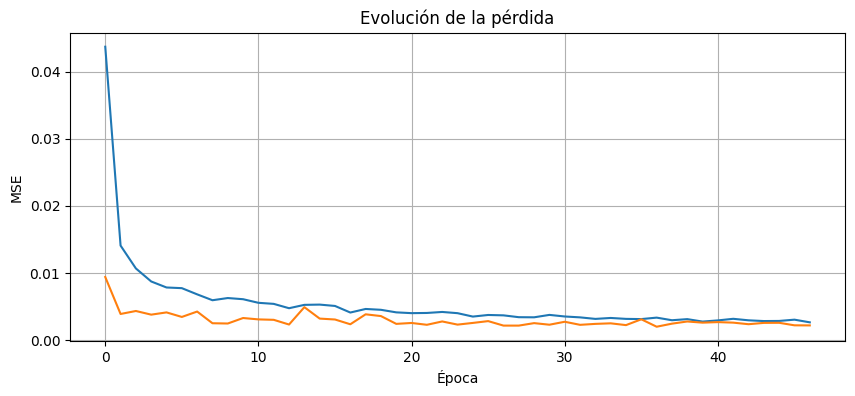

In [93]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Val)')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend
plt.grid(True)
plt.show()

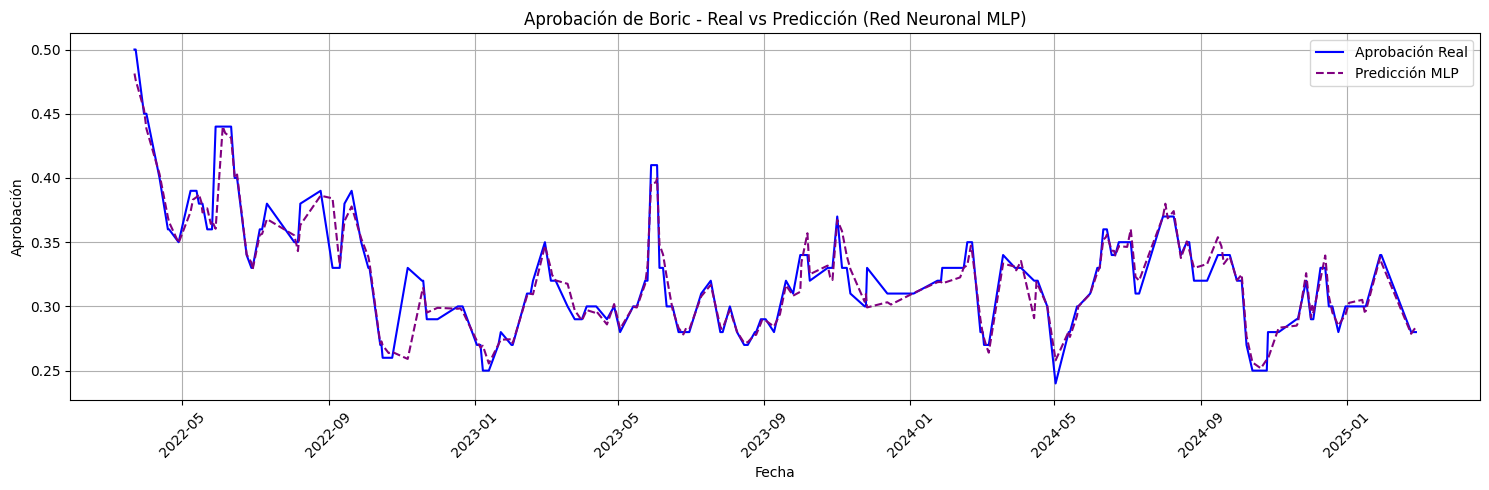

In [94]:
df_result_mlp = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_mlp,
    'Predicción MLP': y_pred_real_mlp
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Predicción MLP'], label='Predicción MLP', color='purple', linestyle='--')
plt.title('Aprobación de Boric - Real vs Predicción (Red Neuronal MLP)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

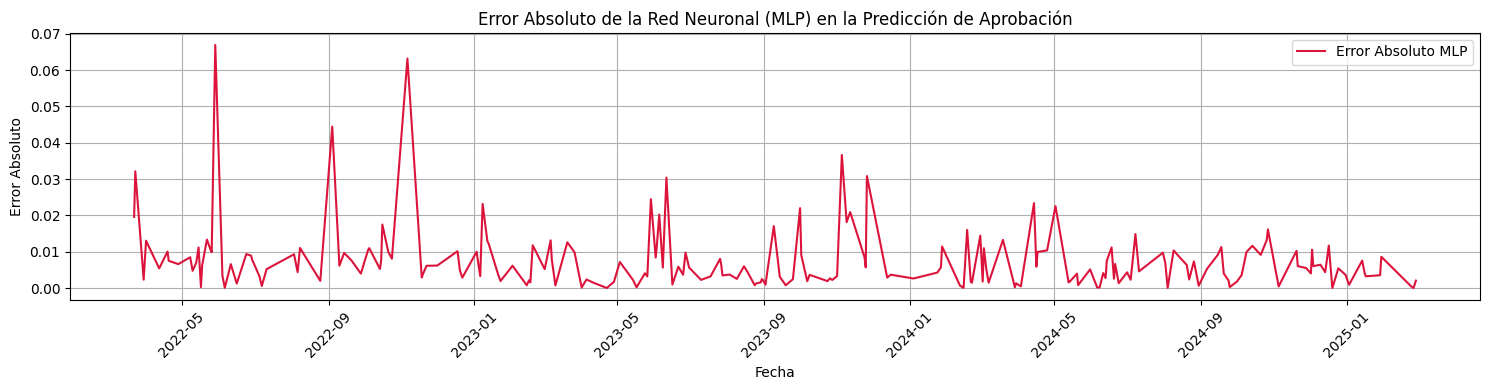

In [74]:
df_result_mlp['Error Absoluto'] = np.abs(df_result_mlp['Aprobación Real'] - df_result_mlp['Predicción MLP'])
plt.figure(figsize=(15, 4))
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Error Absoluto'], color='crimson', label='Error Absoluto MLP')
plt.title('Error Absoluto de la Red Neuronal (MLP) en la Predicción de Aprobación')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comparación de resultados:

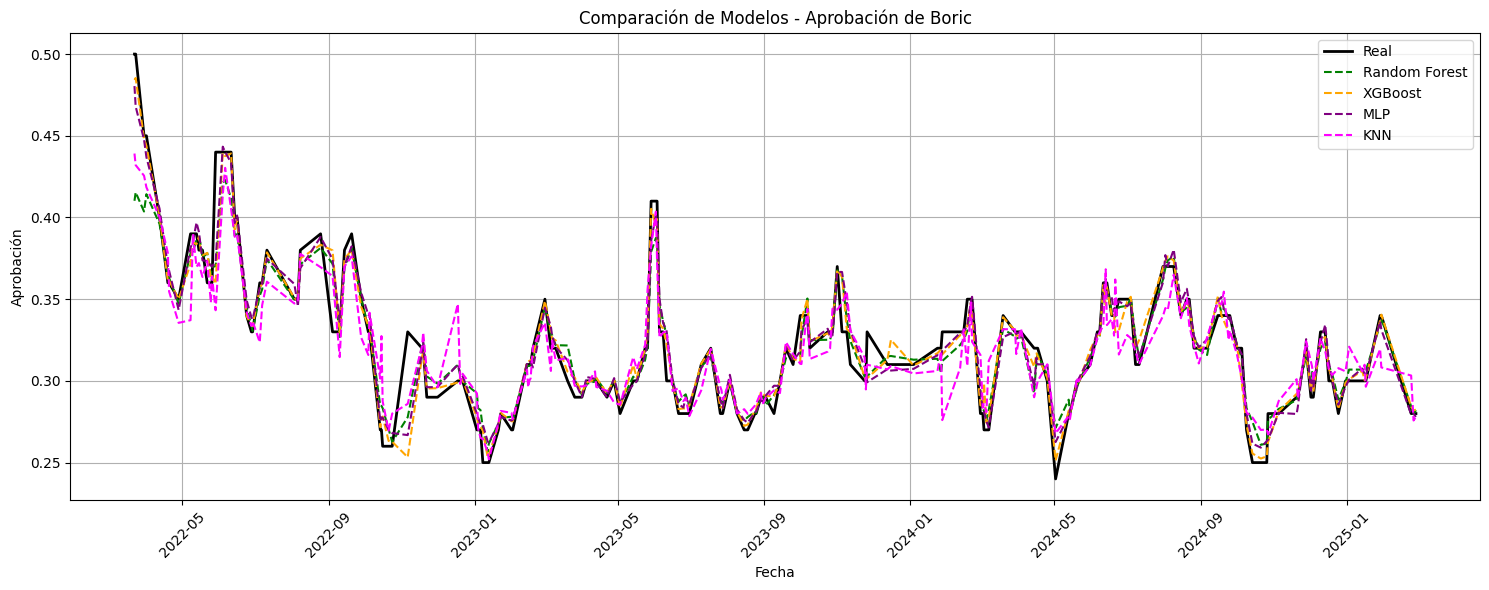

In [75]:
df_comparacion = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real,
    'Random Forest': y_pred_real_rf,
    'XGBoost': y_pred_real_xgb,
    'MLP': y_pred_real_mlp,
    'KNN': y_pred_real_knn
}).sort_values(by='Fecha')

plt.figure(figsize=(15, 6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Aprobación Real'], label='Real', color='black', linewidth=2)
plt.plot(df_comparacion['Fecha'], df_comparacion['Random Forest'], label='Random Forest', linestyle='--', color='green')
plt.plot(df_comparacion['Fecha'], df_comparacion['XGBoost'], label='XGBoost', linestyle='--', color='orange')
plt.plot(df_comparacion['Fecha'], df_comparacion['MLP'], label='MLP', linestyle='--', color='purple')
plt.plot(df_comparacion['Fecha'], df_comparacion['KNN'], label='KNN', linestyle='--', color='magenta')

plt.title('Comparación de Modelos - Aprobación de Boric')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()